## Import

In [2]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Frequency Domain Response Function

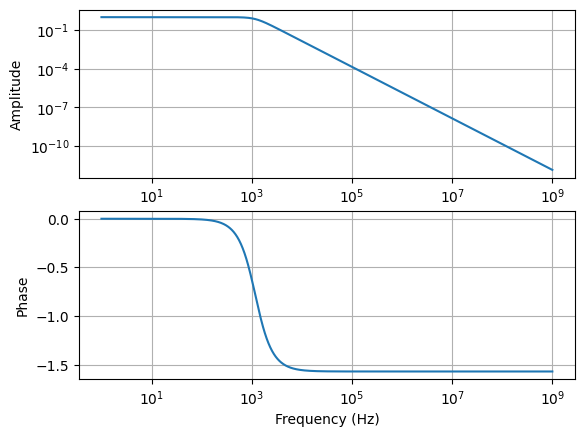

In [3]:
def reactance_factor(freq, temperature_Kelvin):
    temperature_Celcius = temperature_Kelvin - 273.15
    R0 = 8 * 2 + 10  # Ohm
    C = 7e-10 * (1 + temperature_Celcius * 0.00338)  # F
    gamma = 3.3e13
    omega = 2 * np.pi * freq
    im = 1j
    wXp = gamma / (1 + im * omega * C * gamma)
    wX = omega * R0 + wXp
    return torch.where(freq < 0, torch.conj(wXp / wX), wXp / wX)

# plot the reactance_factor in frequency domain (log scale) from 1Hz to 1GHz
# with two subplot : amplitude and phase
f = torch.logspace(0, 9, 1000, base=10).to(device)
X = reactance_factor(f, 273.15)
plt.figure()
plt.subplot(211)
plt.plot(f.cpu().numpy(), torch.abs(X).cpu().numpy())
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.subplot(212)
plt.plot(f.cpu().numpy(), torch.angle(X).cpu().numpy())
plt.xscale('log')
plt.ylabel('Phase')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.show()

# Time Domain Reponse Function

7.5339460372924805


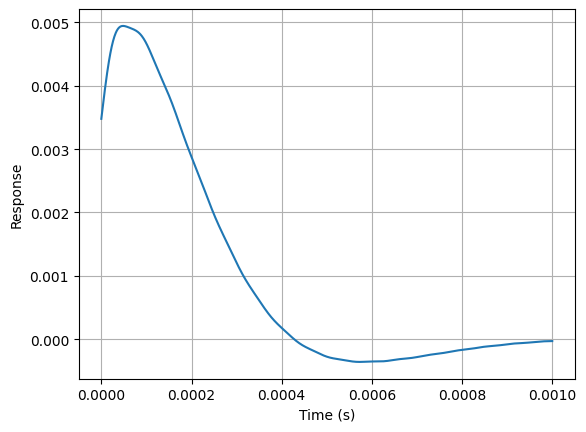

In [4]:
# make time_response_function
def time_response(t_end, dt, temperature=273.15):
    w_end = 1e5
    dw = 10
    w = torch.arange(0, w_end, dw).to(device)
    integrant = lambda w, t: (reactance_factor(w / 2 / np.pi, temperature) * torch.exp(1j * w * t)).real
    integrant_values = torch.stack([integrant(w, t) for t in torch.arange(0, t_end, dt).to(device)])
    integral = torch.trapz(integrant_values, w, dim=1) * dt * dw / np.pi
    print(torch.sum(integral).item())
    return integral / torch.sum(integral)
    
time_end = 1e-3
dt = 1e-6
time_array = torch.arange(0, 1e-3, 1e-6).to(device)
time_response_array = time_response(time_end, dt)
plt.figure()
plt.plot(time_array.cpu().numpy(), time_response_array.cpu().numpy())
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.grid()
plt.show()

# Response at Heaviside Function

7.518970489501953


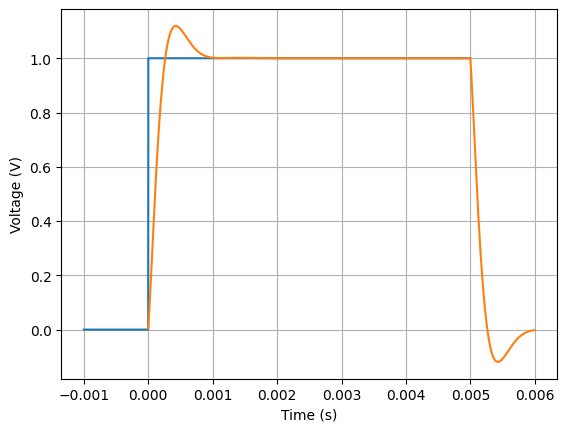

In [5]:
# show the convolution of heaviside voltage and time_response_function
def voltage(t, t_0):
    return torch.where(t < t_0, torch.tensor(0.0, device=device), torch.tensor(1.0, device=device))

def response(voltage_array, time_end, dt, temperature=273.15):
    t_response_f = time_response(time_end, dt, temperature)
    t_response_f = torch.flip(t_response_f, dims=[0])  # Invert the response function
    return torch.nn.functional.conv1d(voltage_array.view(1, 1, -1), t_response_f.view(1, 1, -1), padding='same').view(-1)

suscept_time_end = 2e-3
suscept_dt = 1e-6
time_array = torch.arange(-1e-3, 5e-3, suscept_dt, device=device)
voltage_array = torch.tensor([voltage(t, 0) for t in time_array], device=device)
response_array = response(voltage_array, suscept_time_end, suscept_dt)
plt.figure()
plt.plot(time_array.cpu().numpy(), voltage_array.cpu().numpy())
plt.plot((time_array + suscept_time_end/2).cpu().numpy(), response_array.cpu().numpy())
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()


# Giant Step Simulation

X_stepsize (angs):  347.88086780921066
Z_stepsize (angs):  734.4151653750002
HpM_X:  tensor(774.7194)
HpM_Z:  tensor(1156.4866)
X_voltage_array execution time: 0.0 seconds
Z_voltage_array execution time: 0.0 seconds
7.509418964385986


C:\Users\sh6337\AppData\Local\Temp\ipykernel_27980\13540377.py:8: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1041.)
  return torch.nn.functional.conv1d(voltage_array.view(1, 1, -1), t_response_f.view(1, 1, -1), padding='same').view(-1)


X_response_array execution time: 10.850218772888184 seconds
7.509418964385986
Z_response_array execution time: 10.327254056930542 seconds


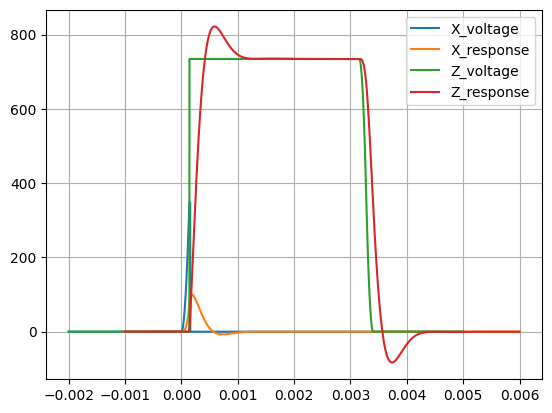

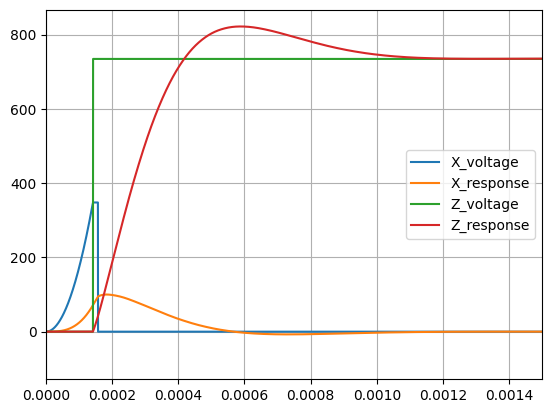

In [6]:
# giant step simulation
CYCLE = 11.625744e-9
OUTPUTCYCLE = 3.6e-6

def X_voltage(t, HpM_X):
    T_parab = torch.sqrt(torch.tensor(2.0, device=device)) * torch.sqrt(HpM_X) * OUTPUTCYCLE
    relax_delay = 5 * 259 * CYCLE
    voltage = torch.zeros_like(t, device=device)
    voltage = torch.where(t < 0, torch.tensor(0.0, device=device), voltage)
    voltage = torch.where((t >= 0) & (t < T_parab), (t / T_parab) ** 2, voltage)
    voltage = torch.where((t >= T_parab) & (t < T_parab + relax_delay), torch.tensor(1.0, device=device), voltage)
    voltage = torch.where(t >= T_parab + relax_delay, torch.tensor(0.0, device=device), voltage)
    return voltage

def Z_voltage(t, HpM_X, HpM_Z, tip_delay):
    T_parab_X = torch.sqrt(torch.tensor(2.0, device=device)) * torch.sqrt(HpM_X) * OUTPUTCYCLE
    T_parab_Z = torch.sqrt(HpM_Z) * OUTPUTCYCLE
    relax_delay = 5 * 259 * CYCLE + tip_delay
    voltage = torch.zeros_like(t, device=device)
    voltage = torch.where(t < T_parab_X, torch.tensor(0.0, device=device), voltage)
    voltage = torch.where((t >= T_parab_X) & (t < T_parab_X + relax_delay), torch.tensor(1.0, device=device), voltage)
    voltage = torch.where((t >= T_parab_X + relax_delay) & (t < T_parab_X + relax_delay + T_parab_Z), 1 - 0.5 * ((t - T_parab_X - relax_delay) / T_parab_Z)**2, voltage)
    voltage = torch.where((t >= T_parab_X + relax_delay + T_parab_Z) & (t < T_parab_X + relax_delay + T_parab_Z * 2), 0.5 * ((t - T_parab_X - relax_delay - T_parab_Z * 2) / T_parab_Z)**2, voltage)
    voltage = torch.where(t >= T_parab_X + relax_delay + T_parab_Z * 2, torch.tensor(0.0, device=device), voltage)
    return voltage


class Piezo():
    def __init__(self, temperature):
        self.temperature = temperature
        self.length = 1.27e8 # 12.7 mm in angs
        self.thickness = 7.62e6 # 0.762 mm in angs
        self.mean_diameter = 2.413e7 # 2.413 mm in angs

    def d31(self):
        temp = self.temperature
        temp2 = temp * temp
        temp3 = temp2 * temp
        temp4 = temp3 * temp
        temp5 = temp4 * temp
        a0 = 38.6587	- 10.05373351
        a1 = 0.483506 + 0.084041014
        a2 = 0.000706133
        a3 = -0.0000154086
        a4 = 0.0000000693543
        a5 = -0.0000000000954317
        return (a0 + a1 * temp + a2 * temp2 + a3 * temp3 + a4 * temp4 + a5 * temp5) / 100.0

    
    def angs(self, voltage):
        return 0.9 * self.d31() * voltage * self.length * self.length / self.mean_diameter / self.thickness
    
    def z_angs(self, voltage):
        return self.d31() * voltage * self.length / self.thickness

tip_delay = 3e-3
a_percent = 1 # percent of gravity acceleration
X_stepsize = 2.5 # V
Z_stepsize = 2.5 # V

temperature = 300  # K
piezo = Piezo(temperature)
X_angs = piezo.angs(X_stepsize)
Z_angs = piezo.z_angs(Z_stepsize) * 10
acceleration = a_percent * 9.8 * 1e10  # angstrom / s^2
HpM_X = 2 * torch.sqrt(torch.tensor(2.0, device=device)) * X_angs / acceleration / OUTPUTCYCLE / OUTPUTCYCLE
HpM_Z = 2 * torch.tensor(Z_angs, device=device) / acceleration / OUTPUTCYCLE / OUTPUTCYCLE
print("X_stepsize (angs): ", X_angs)
print("Z_stepsize (angs): ", Z_angs)
print("HpM_X: ", HpM_X)
print("HpM_Z: ", HpM_Z)

suscept_time_end = 2e-3
suscept_dt = 1e-7
time_array = torch.arange(-2e-3, 5e-3, suscept_dt, device=device)
start_time = time.time()
X_voltage_array = X_angs * X_voltage(time_array, HpM_X)
print(f"X_voltage_array execution time: {time.time() - start_time} seconds")

start_time = time.time()
Z_voltage_array = Z_angs * Z_voltage(time_array, HpM_X, HpM_Z, tip_delay)
print(f"Z_voltage_array execution time: {time.time() - start_time} seconds")

start_time = time.time()
X_response_array = response(X_voltage_array, suscept_time_end, suscept_dt, temperature)
print(f"X_response_array execution time: {time.time() - start_time} seconds")

start_time = time.time()
Z_response_array = response(Z_voltage_array, suscept_time_end, suscept_dt, temperature)
print(f"Z_response_array execution time: {time.time() - start_time} seconds")

plt.figure()
plt.plot(time_array.cpu().numpy(), X_voltage_array.cpu().numpy(), label='X_voltage')
plt.plot((time_array + suscept_time_end/2).cpu().numpy(), X_response_array.cpu().numpy(), label='X_response')
plt.plot(time_array.cpu().numpy(), Z_voltage_array.cpu().numpy(), label='Z_voltage')
plt.plot((time_array + suscept_time_end/2).cpu().numpy(), Z_response_array.cpu().numpy(), label='Z_response')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time_array.cpu().numpy(), X_voltage_array.cpu().numpy(), label='X_voltage')
plt.plot((time_array + suscept_time_end/2).cpu().numpy(), X_response_array.cpu().numpy(), label='X_response')
plt.plot(time_array.cpu().numpy(), Z_voltage_array.cpu().numpy(), label='Z_voltage')
plt.plot((time_array + suscept_time_end/2).cpu().numpy(), Z_response_array.cpu().numpy(), label='Z_response')
plt.xlim(0, 0.0015)
plt.legend()
plt.grid()
plt.show()

# Show Trajectory

max z_accel (angs/s^2):  12279528554496.0
min z_accel (angs/s^2):  -134276874240.0
12
12
12


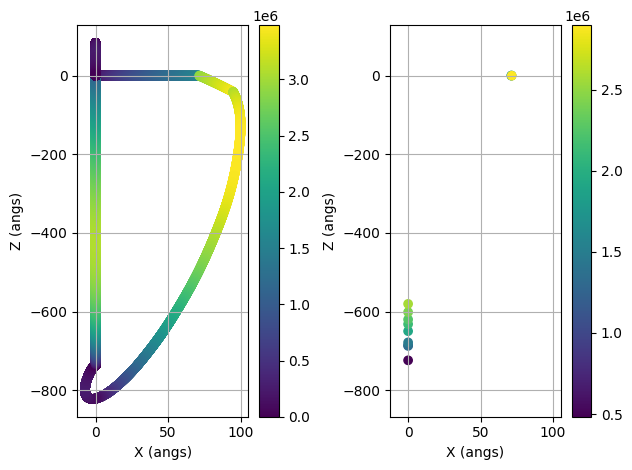

In [7]:
def speed(X_response_array, Z_response_array, dt):
    X_grad = torch.gradient(X_response_array, spacing=dt, edge_order=2)[0]
    Z_grad = torch.gradient(Z_response_array, spacing=dt, edge_order=2)[0]
    return torch.sqrt(X_grad**2 + Z_grad**2)

def z_acceleration(Z_response_array, dt):
    Z_grad2 = torch.gradient(torch.gradient(Z_response_array, spacing=dt, edge_order=2)[0], spacing=dt, edge_order=2)[0]
    return Z_grad2

speed_array = speed(X_response_array, Z_response_array, suscept_dt)
z_accel_array = z_acceleration(Z_response_array, suscept_dt)
print("max z_accel (angs/s^2): ", torch.max(z_accel_array).item())
print("min z_accel (angs/s^2): ", torch.min(z_accel_array).item())

filtered_indices = torch.abs(z_accel_array) > 9.8e10
filtered_X_response_array = X_response_array[filtered_indices]
filtered_Z_response_array = Z_response_array[filtered_indices]
filtered_speed_array = speed_array[filtered_indices]

print(len(filtered_X_response_array))
print(len(filtered_Z_response_array))
print(len(filtered_speed_array))

plt.figure()
plt.subplot(121)
plt.scatter(X_response_array.cpu().numpy(), -Z_response_array.cpu().numpy(), c=speed_array.cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel('X (angs)')
plt.ylabel('Z (angs)')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

plt.subplot(122)
plt.scatter(filtered_X_response_array.cpu().numpy(), -filtered_Z_response_array.cpu().numpy(), c=filtered_speed_array.cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel('X (angs)')
plt.ylabel('Z (angs)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.show()

# Guess Sample Trajectory (w/o Slope of Sample Holder)

X Jump Distance =  tensor(0.0002)  at  11416
Z Jump Distance =  tensor(-6.9952e-06)  at  11416
X Jump Distance =  tensor(-7.6294e-06)  at  11417
Z Jump Distance =  tensor(3.3311e-07)  at  11417
X Jump Distance =  tensor(76.9640)  at  12088
Z Jump Distance =  tensor(-3.3603)  at  12088


Text(0, 0.5, 'Z (angs)')

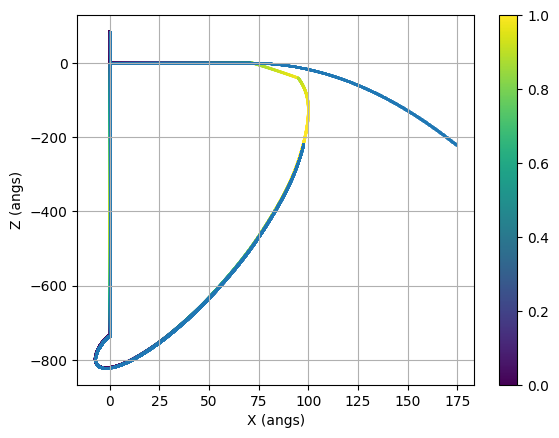

In [8]:
def guess_sample_trajectory(X_response_array, Z_response_array, dt, tilting_radian=0):
    # note that Z is inverted
    x_speed_array = torch.gradient(X_response_array, spacing=dt, edge_order=2)[0]
    z_accel_array = z_acceleration(Z_response_array, dt)
    new_X_sample = torch.zeros(len(X_response_array), device=device)
    new_Z_sample = torch.zeros(len(Z_response_array), device=device)
    gravity = 9.8e10
    flying = False
    flying_x_speed = 0
    flying_z_speed = 0
    total_jump_distance = 0
    for i in range(len(X_response_array)):
        if not flying:
            if z_accel_array[i] > gravity:
                flying_x_speed = x_speed_array[i]
                flying_z_speed = 0.5 * gravity * dt
                flying = True
            else:
                new_X_sample[i] = X_response_array[i]
                new_Z_sample[i] = Z_response_array[i]
        if flying:
            guessed_dx = flying_x_speed * dt
            flying_z_speed += gravity * dt
            guessed_dz = flying_z_speed * dt
            guessed_flying_x = new_X_sample[i-1] + guessed_dx
            guessed_flying_z = new_Z_sample[i-1] + guessed_dz
            if Z_response_array[i] < guessed_flying_z + torch.tan(torch.tensor(tilting_radian, device=device)) * (guessed_flying_x - X_response_array[i]):
                print("X Jump Distance = ", (guessed_flying_x - X_response_array[i]), " at ", i)
                print("Z Jump Distance = ", torch.tan(torch.tensor(tilting_radian, device=device)) * (guessed_flying_x - X_response_array[i]), " at ", i)
                total_jump_distance += guessed_flying_x - X_response_array[i]
                flying = False
                new_X_sample[i] = X_response_array[i]
                new_Z_sample[i] = Z_response_array[i]
            else:
                new_X_sample[i] = guessed_flying_x
                new_Z_sample[i] = guessed_flying_z
    return new_X_sample, new_Z_sample, total_jump_distance

tilting_radian = -2.5 * np.pi / 180
X_sample, Z_sample, _ = guess_sample_trajectory(X_response_array, Z_response_array, suscept_dt, tilting_radian)

plt.figure()
plt.scatter(X_response_array.cpu().numpy(), -Z_response_array.cpu().numpy(), c=speed_array.cpu().numpy(), cmap='viridis', s=1)
plt.scatter(X_sample.cpu().numpy(), -Z_sample.cpu().numpy(), s=1)
plt.colorbar()
plt.grid()
plt.xlabel('X (angs)')
plt.ylabel('Z (angs)')

# Make flying distance Parameter Map

In [9]:
import threading

def get_flying_distance(a_percent, stepsize, temperature=273.15):
    tip_delay = 3e-3
    X_stepsize = stepsize
    Z_stepsize = stepsize

    piezo = Piezo(temperature)
    X_angs = piezo.angs(X_stepsize)
    Z_angs = piezo.z_angs(Z_stepsize) * 10
    acceleration = a_percent * 9.8 * 1e10  # angstrom / s^2
    HpM_X = 2 * torch.sqrt(torch.tensor(2.0, device=device)) * X_angs / acceleration / OUTPUTCYCLE / OUTPUTCYCLE
    HpM_Z = 2 * torch.tensor(Z_angs, device=device) / acceleration / OUTPUTCYCLE / OUTPUTCYCLE

    suscept_time_end = 1.5e-3
    suscept_dt = 1e-7
    time = torch.arange(-1.5e-3, 2e-3, suscept_dt, device=device)
    X_voltage_array = X_angs * X_voltage(time, HpM_X)
    Z_voltage_array = Z_angs * Z_voltage(time, HpM_X, HpM_Z, tip_delay)
    X_response_array = response(X_voltage_array, suscept_time_end, suscept_dt, temperature)
    Z_response_array = response(Z_voltage_array, suscept_time_end, suscept_dt, temperature)

    tilting_radian = -2.5 * np.pi / 180
    _, _, jump_distance = guess_sample_trajectory(X_response_array, Z_response_array, suscept_dt, tilting_radian)
    return jump_distance

a_percent_list = np.linspace(0.1, 10, 100)
stepsize_list = np.linspace(0.1, 10, 100)
num_threads = 4
lock = threading.Lock()

def worker(a_percent, stepsize):
    with lock:
        with open('result.txt', 'r') as f:
            if f.read().find(str(a_percent) + ' ' + str(stepsize)) != -1:
                return
    jump_distance = get_flying_distance(a_percent, stepsize).item()
    with lock:
        with open('result.txt', 'a') as f:
            f.write(str(a_percent) + ' ' + str(stepsize) + ' ' + str(jump_distance) + '\n')
    print(a_percent, stepsize, jump_distance)

threads = []
for a_percent in a_percent_list:
    for stepsize in stepsize_list:
        if len(threads) >= num_threads:
            for t in threads:
                t.join()
            threads = []
        t = threading.Thread(target=worker, args=(a_percent, stepsize))
        t.start()
        threads.append(t)

for t in threads:
    t.join()

7.51824951171875
7.51824951171875
7.51824951171875
7.51824951171875
7.51824951171875
7.51824951171875
7.51824951171875
7.51824951171875
X Jump Distance =  tensor(-3.0518e-05)  at  9449
Z Jump Distance =  tensor(1.3324e-06)  at  9449
X Jump Distance =  tensor(0.0003)  at  9450
Z Jump Distance =  tensor(-1.1326e-05)  at  9450
X Jump Distance =  tensor(0.0001)  at  9490
Z Jump Distance =  tensor(-5.3297e-06)  at  9490
X Jump Distance =  tensor(0.0001)  at  9491
Z Jump Distance =  tensor(-4.6635e-06)  at  9491
X Jump Distance =  tensor(0.0001)  at  9427
Z Jump Distance =  tensor(-5.9959e-06)  at  9427
X Jump Distance =  tensor(0.)  at  9428
Z Jump Distance =  tensor(-0.)  at  9428
X Jump Distance =  tensor(0.0002)  at  9470
Z Jump Distance =  tensor(-7.3283e-06)  at  9470
X Jump Distance =  tensor(-3.0518e-05)  at  9471
Z Jump Distance =  tensor(1.3324e-06)  at  9471
X Jump Distance =  tensor(328.5092)  at  10663
Z Jump Distance =  tensor(-14.3430)  at  10663
X Jump Distance =  tensor(361.